In [1]:
import os, json, glob, random
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

2024-06-01 21:17:52.331897: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 21:17:52.331951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 21:17:52.333230: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-01 21:17:52.339943: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gemini_dataset = '/home/trainer/dev/sonar/datasets/gemini'
files = glob.glob(os.path.join(gemini_dataset, '*.png'))

In [3]:
random_file = files[random.randint(0, len(files)+1)]
im = tf.image.decode_png(tf.io.read_file(os.path.join(gemini_dataset, random_file)))

2024-06-01 21:18:09.947414: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-01 21:18:09.961548: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-01 21:18:09.966303: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

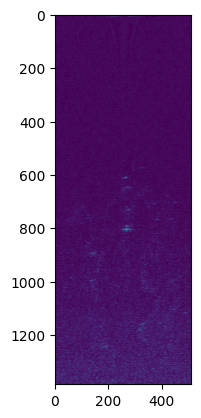

In [4]:
plt.imshow(im.numpy());

In [52]:
maxv = tf.reduce_max(im)
minv = tf.reduce_min(im)

In [53]:
patch_size = 128

In [73]:
patches = tf.image.extract_patches(
    tf.expand_dims(im, axis=0),
    [1, patch_size, patch_size, 1],
    [1, patch_size//2, patch_size//2, 1],
    [1, 1, 1, 1],
    'VALID')

In [74]:
patches.shape

TensorShape([1, 23, 7, 16384])

In [75]:
ycells, xcells = patches.shape[1:3]

In [76]:
patches = tf.reshape(patches, (ycells, xcells, patch_size, patch_size, 1))
patches = tf.cast(patches, tf.float32) / tf.cast(maxv, tf.float32) # tf.image.convert_image_dtype(patches, tf.float32)

In [77]:
# Initialize model
from sonar.jigsaw.model import create_feature_extractor

weights = '/home/trainer/dev/sonar/expt/generated/jigsaw-mobinetv3s-192x192/train/backbone_weights/backbone_weights.h5'
#fe = keras.models.load_model(weights)
fe = create_feature_extractor(image_width=128, image_height=128, preset_model='mobilenetv3small')
fe.load_weights(weights)

In [78]:
features = fe(tf.reshape(patches, (ycells*xcells, patch_size, patch_size, 1)))

In [80]:
features.shape

TensorShape([161, 6912])

In [79]:
features = tf.reshape(features, (ycells*xcells, -1))

In [61]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [81]:
embed2d = TSNE(2).fit_transform(features)

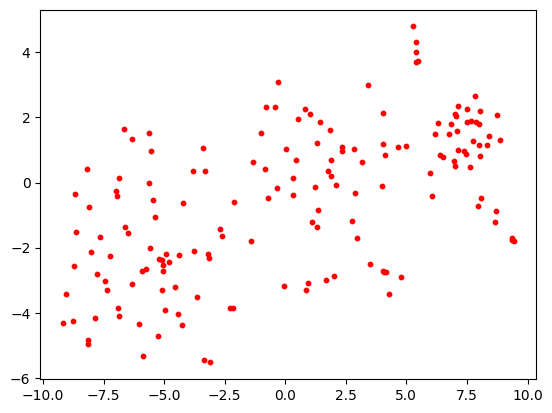

In [82]:
fig, ax = plt.subplots()
ax.scatter(embed2d[:, 0], embed2d[:, 1], 10, 'red');
# for i, coord in enumerate(coords): ax.annotate('({}, {})'.format(coord[0], coord[1]), (embed2d[i, 0], embed2d[i, 1]));

In [83]:
patches = tf.reshape(patches, (ycells * xcells, patch_size, patch_size))

In [84]:
embed1d = TSNE(1).fit_transform(features)
indexes = np.argsort(embed1d.ravel())
sorted_patches = [patches[i] for i in indexes.tolist()]
spectrum = tf.concat(sorted_patches, axis=-1)

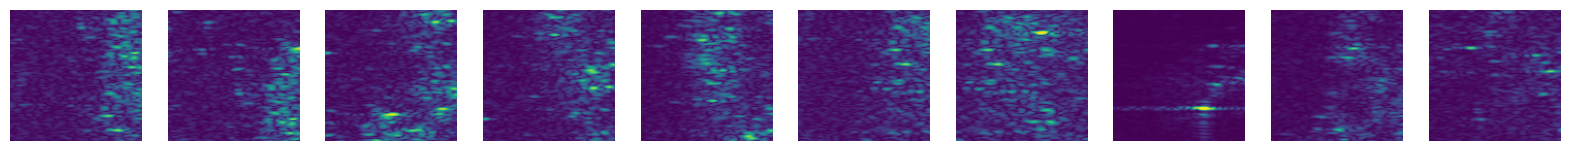

In [94]:
fig, axes = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10): axes[i].imshow(sorted_patches[i], vmin=0., vmax=1.); axes[i].axis('off');

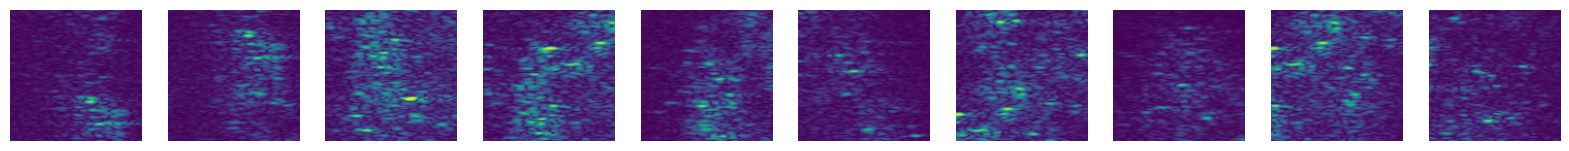

In [95]:
fig, axes = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10): axes[i].imshow(sorted_patches[10+i], vmin=0, vmax=1.0); axes[i].axis('off');

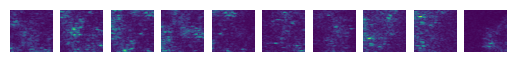

In [87]:
fig, axes = plt.subplots(1, 10)
for i in range(10): axes[i].imshow(sorted_patches[20+i], vmin=0, vmax=1); axes[i].axis('off');

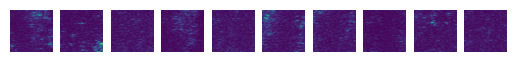

In [88]:
fig, axes = plt.subplots(1, 10)
for i in range(10): axes[i].imshow(sorted_patches[30+i], vmin=0, vmax=1); axes[i].axis('off');

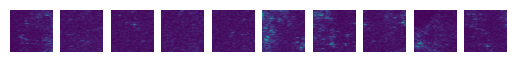

In [89]:
fig, axes = plt.subplots(1, 10)
for i in range(10): axes[i].imshow(sorted_patches[40+i], vmin=0, vmax=1); axes[i].axis('off');

In [70]:
len(patches)

48